# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from PIL import Image
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassConfusionMatrix

from torcheval.metrics import BinaryAccuracy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [4]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [5]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Define function loading GTZAN df from file

In [6]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/98/100
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [7]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [ ]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [6]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [7]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [7]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [8]:
# 0, 1, 2, 3... labels used with nn.CrossEntropyLoss
def numerically_encode_class_label(class_name, available_classes):
  return available_classes.index(class_name)

# currently unused
def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = numerically_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, numerical_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(numerical_label, device=device) #! DATA on device

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader

In [10]:
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

With val

In [11]:
BATCH_SIZE = 32
CHANNELS = 3

In [12]:
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN from DataLoader

Done on CPU

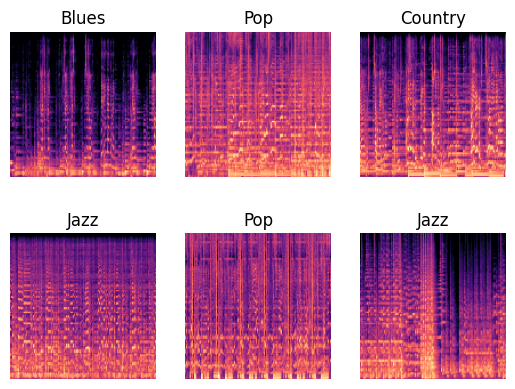

In [ ]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model, metrics and loops - PyTorch

In [13]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened feature map
        self.flattened_size = (img_size // 16) * (img_size // 16) * 128
        # max pooling reduces image width by /16 and image height by /16
        # 128 is the number of kernels in the last convolutional layer
        
        self.fc = nn.Linear(self.flattened_size, num_classes) # Logits, not probabilities
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = self.fc(x)
        
        return x

In [14]:
# metrics calculated and displayed every epoch on val loop
# can be used on test loop
def create_multiclass_metrics(num_classes):
    return { "macro_accuracy": MulticlassAccuracy(device=device, average='macro', num_classes=num_classes),
             "micro_accuracy": MulticlassAccuracy(device=device, average='micro'),
             "accuracy_per_class": MulticlassAccuracy(device=device, average=None, num_classes=num_classes),
             
             "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
             "micro_precision": MulticlassPrecision(device=device, average='micro'),
             "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
             
             "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),
             "micro_recall": MulticlassRecall(device=device, average='micro'),
             "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes),            
            }
    
# additional metrics to use during testing
def create_post_loop_multiclass_metrics(num_classes):
    return { "confusion_matrix": MulticlassConfusionMatrix(device=device, num_classes=num_classes),
           }

In [15]:
import numpy as np

def draw_confusion_matrix(multiclass_confusion_matrix, class_names):    
    multiclass_confusion_matrix = np.array(multiclass_confusion_matrix)  # Convert to NumPy array
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(multiclass_confusion_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='left')
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, int(multiclass_confusion_matrix[i, j]), ha='center', va='center', color='black')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def reset_metrics(metrics):
    [metric.reset() for metric in metrics.values()]

def update_metrics(metrics, logits, labels):
    [metric.update(logits, labels) for metric in metrics.values()]

def compute_metrics(metrics):
    return {name: metric.compute() for name, metric in metrics.items()}

def print_metrics(metrics, class_names): 
    for name, metric in metrics.items():
        value = metric.tolist()
        
        if (name == 'confusion_matrix'):
            draw_confusion_matrix(value, class_names)
        elif isinstance(value, list):  # one number result for each class
            [print(f"{class_names[i]}: {value[i]:.4f}", end=" ") for i in range(len(value))]
            print()
        else:                          # one number result for all classes
            print(f"{name}: {value:.4f}")    

In [17]:
# Test loop
def test_loop(model, metrics, class_names, test_dl):
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    results_copy = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metrics(results_copy, class_names)
    reset_metrics(metrics)
    return results_copy

In [18]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, metrics, class_names, train_dl, val_dl = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop has only Accuracy/Micro-accuracy to roughly monitor progress without spamming the console
    # Val/Test loop has all the metrics
    training_accuracy = BinaryAccuracy(device=device) if is_binary_classification else MulticlassAccuracy(device=device, average='micro')
    
    # Training loop
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            training_accuracy.update(outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dl)}, Training Accuracy: {training_accuracy.compute():.4f}")    
        training_accuracy.reset()
        
        # Validation at end of epoch if val_dl is provided
        if val_dl is not None:
            print("Validation:") 
            test_loop(model,  metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [19]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(gtzan_classes)).to(device) #! model to device
gtzan_multiclass_metrics = create_multiclass_metrics(num_classes=len(gtzan_classes))

epochs: 25

| batch_size | val macro-accuracy | test macro-accuracy |
| ----| ------ |------|
| 32  | 64.4%  | 58%  |


Note:

issue https://github.com/pytorch/torcheval/pull/199 for TorchEval mentions that the warning message for MulticlassPrecision(average=None) is misleading.

The warning says that both the ground truth AND predictions have n=0 for some classes, but in fact it takes only ground truth OR predictions to have n=0 for this warning to appear. So, if a model just never predicts a particular class in an epoch, this warning appears despite it not being an architectural mistake.

In [26]:
training_loop(model_gtzan, 21, gtzan_multiclass_metrics, gtzan_classes, gtzan_train_dl, gtzan_val_dl)

Epoch 1, Loss: 1.4538270783424379, Training Accuracy: 0.5263
Validation:
macro_accuracy: 0.5267
micro_accuracy: 0.5306
Blues: 0.2000 Classical: 1.0000 Country: 0.2000 Disco: 0.0000 Hip-Hop: 0.9000 Jazz: 0.2222 Metal: 0.7000 Pop: 0.9000 Reggae: 0.4444 Rock: 0.7000 
macro_precision: 0.5862
micro_precision: 0.5306
Blues: 1.0000 Classical: 0.5263 Country: 0.6667 Disco: 0.0000 Hip-Hop: 0.4286 Jazz: 1.0000 Metal: 0.6364 Pop: 0.6923 Reggae: 0.5000 Rock: 0.4118 
macro_recall: 0.5267
micro_recall: 0.5306
Blues: 0.2000 Classical: 1.0000 Country: 0.2000 Disco: 0.0000 Hip-Hop: 0.9000 Jazz: 0.2222 Metal: 0.7000 Pop: 0.9000 Reggae: 0.4444 Rock: 0.7000 


        [3],
        [6],
        [9]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


Epoch 2, Loss: 1.1218236470222473, Training Accuracy: 0.6413
Validation:
macro_accuracy: 0.2889
micro_accuracy: 0.2857
Blues: 0.1000 Classical: 0.3000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 0.7000 Jazz: 0.0000 Metal: 0.0000 Pop: 0.9000 Reggae: 0.8889 Rock: 0.0000 
macro_precision: 0.1739
micro_precision: 0.2857
Blues: 0.2000 Classical: 0.6000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 0.2000 Jazz: 0.0000 Metal: 0.0000 Pop: 0.3750 Reggae: 0.3636 Rock: 0.0000 
macro_recall: 0.2889
micro_recall: 0.2857
Blues: 0.1000 Classical: 0.3000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 0.7000 Jazz: 0.0000 Metal: 0.0000 Pop: 0.9000 Reggae: 0.8889 Rock: 0.0000 


Epoch 3, Loss: 1.0767617702484131, Training Accuracy: 0.6275
Validation:
macro_accuracy: 0.4911
micro_accuracy: 0.4898
Blues: 0.4000 Classical: 1.0000 Country: 0.2000 Disco: 0.1000 Hip-Hop: 1.0000 Jazz: 0.4444 Metal: 0.6000 Pop: 0.5000 Reggae: 0.6667 Rock: 0.0000 
macro_precision: 0.5014
micro_precision: 0.4898
Blues: 0.5000 Classical: 0.7692 Country: 0.6667 Disco: 0.0909 Hip-Hop: 0.3448 Jazz: 0.8000 Metal: 0.6667 Pop: 0.7143 Reggae: 0.4615 Rock: 0.0000 
macro_recall: 0.4911
micro_recall: 0.4898
Blues: 0.4000 Classical: 1.0000 Country: 0.2000 Disco: 0.1000 Hip-Hop: 1.0000 Jazz: 0.4444 Metal: 0.6000 Pop: 0.5000 Reggae: 0.6667 Rock: 0.0000 
Epoch 4, Loss: 0.922479133605957, Training Accuracy: 0.6725
Validation:
macro_accuracy: 0.5411
micro_accuracy: 0.5408
Blues: 0.3000 Classical: 0.6000 Country: 0.7000 Disco: 0.1000 Hip-Hop: 0.5000 Jazz: 0.4444 Metal: 0.6000 Pop: 0.9000 Reggae: 0.6667 Rock: 0.6000 
macro_precision: 0.5956
micro_precision: 0.5408
Blues: 0.5000 Classical: 0.7500 Country: 

Epoch 8, Loss: 0.5825441974401474, Training Accuracy: 0.7875
Validation:
macro_accuracy: 0.4133
micro_accuracy: 0.4082
Blues: 0.2000 Classical: 0.3000 Country: 0.0000 Disco: 0.1000 Hip-Hop: 1.0000 Jazz: 0.4444 Metal: 0.1000 Pop: 0.9000 Reggae: 0.8889 Rock: 0.2000 
macro_precision: 0.5210
micro_precision: 0.4082
Blues: 0.4000 Classical: 1.0000 Country: 0.0000 Disco: 0.1429 Hip-Hop: 0.3704 Jazz: 0.3077 Metal: 1.0000 Pop: 0.6923 Reggae: 0.2963 Rock: 1.0000 
macro_recall: 0.4133
micro_recall: 0.4082
Blues: 0.2000 Classical: 0.3000 Country: 0.0000 Disco: 0.1000 Hip-Hop: 1.0000 Jazz: 0.4444 Metal: 0.1000 Pop: 0.9000 Reggae: 0.8889 Rock: 0.2000 


        [9]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


Epoch 9, Loss: 0.602313369512558, Training Accuracy: 0.7925
Validation:
macro_accuracy: 0.4867
micro_accuracy: 0.4796
Blues: 0.4000 Classical: 0.9000 Country: 0.2000 Disco: 0.3000 Hip-Hop: 1.0000 Jazz: 0.7778 Metal: 0.0000 Pop: 0.4000 Reggae: 0.8889 Rock: 0.0000 
macro_precision: 0.5061
micro_precision: 0.4796
Blues: 0.4444 Classical: 0.9000 Country: 1.0000 Disco: 0.1875 Hip-Hop: 0.3704 Jazz: 0.7778 Metal: 0.0000 Pop: 1.0000 Reggae: 0.3810 Rock: 0.0000 
macro_recall: 0.4867
micro_recall: 0.4796
Blues: 0.4000 Classical: 0.9000 Country: 0.2000 Disco: 0.3000 Hip-Hop: 1.0000 Jazz: 0.7778 Metal: 0.0000 Pop: 0.4000 Reggae: 0.8889 Rock: 0.0000 


        [6]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


Epoch 10, Loss: 0.5838046646118165, Training Accuracy: 0.7900
Validation:
macro_accuracy: 0.4344
micro_accuracy: 0.4286
Blues: 0.3000 Classical: 0.3000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 1.0000 Jazz: 0.6667 Metal: 0.0000 Pop: 1.0000 Reggae: 0.7778 Rock: 0.3000 
macro_precision: 0.4088
micro_precision: 0.4286
Blues: 0.4286 Classical: 1.0000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 0.4000 Jazz: 0.3750 Metal: 0.0000 Pop: 0.6250 Reggae: 0.2593 Rock: 1.0000 
macro_recall: 0.4344
micro_recall: 0.4286
Blues: 0.3000 Classical: 0.3000 Country: 0.0000 Disco: 0.0000 Hip-Hop: 1.0000 Jazz: 0.6667 Metal: 0.0000 Pop: 1.0000 Reggae: 0.7778 Rock: 0.3000 


Epoch 11, Loss: 0.5368655061721802, Training Accuracy: 0.8175
Validation:
macro_accuracy: 0.6078
micro_accuracy: 0.6020
Blues: 0.3000 Classical: 0.5000 Country: 0.6000 Disco: 0.0000 Hip-Hop: 0.9000 Jazz: 0.7778 Metal: 0.4000 Pop: 0.8000 Reggae: 1.0000 Rock: 0.8000 
macro_precision: 0.6524
micro_precision: 0.6020
Blues: 0.7500 Classical: 1.0000 Country: 1.0000 Disco: 0.0000 Hip-Hop: 0.7500 Jazz: 0.4667 Metal: 1.0000 Pop: 0.7273 Reggae: 0.4091 Rock: 0.4211 
macro_recall: 0.6078
micro_recall: 0.6020
Blues: 0.3000 Classical: 0.5000 Country: 0.6000 Disco: 0.0000 Hip-Hop: 0.9000 Jazz: 0.7778 Metal: 0.4000 Pop: 0.8000 Reggae: 1.0000 Rock: 0.8000 


Epoch 12, Loss: 0.4745358711481094, Training Accuracy: 0.8288
Validation:
macro_accuracy: 0.5989
micro_accuracy: 0.5918
Blues: 0.4000 Classical: 0.4000 Country: 0.8000 Disco: 0.0000 Hip-Hop: 0.6000 Jazz: 0.8889 Metal: 0.6000 Pop: 0.9000 Reggae: 1.0000 Rock: 0.4000 
macro_precision: 0.6468
micro_precision: 0.5918
Blues: 0.8000 Classical: 1.0000 Country: 0.5714 Disco: 0.0000 Hip-Hop: 1.0000 Jazz: 0.4000 Metal: 1.0000 Pop: 0.7500 Reggae: 0.3750 Rock: 0.5714 
macro_recall: 0.5989
micro_recall: 0.5918
Blues: 0.4000 Classical: 0.4000 Country: 0.8000 Disco: 0.0000 Hip-Hop: 0.6000 Jazz: 0.8889 Metal: 0.6000 Pop: 0.9000 Reggae: 1.0000 Rock: 0.4000 
Epoch 13, Loss: 0.45437890470027925, Training Accuracy: 0.8512
Validation:
macro_accuracy: 0.6844
micro_accuracy: 0.6837
Blues: 0.4000 Classical: 0.9000 Country: 0.6000 Disco: 0.2000 Hip-Hop: 1.0000 Jazz: 0.6667 Metal: 0.7000 Pop: 1.0000 Reggae: 0.7778 Rock: 0.6000 
macro_precision: 0.7207
micro_precision: 0.6837
Blues: 0.5714 Classical: 0.8182 Count

Epoch 21, Loss: 0.1870391446352005, Training Accuracy: 0.9350
Validation:
macro_accuracy: 0.5922
micro_accuracy: 0.5918
Blues: 0.6000 Classical: 1.0000 Country: 0.4000 Disco: 0.0000 Hip-Hop: 0.8000 Jazz: 0.7778 Metal: 0.7000 Pop: 0.9000 Reggae: 0.4444 Rock: 0.3000 
macro_precision: 0.5511
micro_precision: 0.5918
Blues: 0.6667 Classical: 0.5556 Country: 0.6667 Disco: 0.0000 Hip-Hop: 0.5333 Jazz: 0.5385 Metal: 0.7000 Pop: 0.7500 Reggae: 0.8000 Rock: 0.3000 
macro_recall: 0.5922
micro_recall: 0.5918
Blues: 0.6000 Classical: 1.0000 Country: 0.4000 Disco: 0.0000 Hip-Hop: 0.8000 Jazz: 0.7778 Metal: 0.7000 Pop: 0.9000 Reggae: 0.4444 Rock: 0.3000 


macro_accuracy: 0.5700
micro_accuracy: 0.5700
Blues: 0.6000 Classical: 0.9000 Country: 0.4000 Disco: 0.0000 Hip-Hop: 0.7000 Jazz: 0.8000 Metal: 0.9000 Pop: 0.5000 Reggae: 0.6000 Rock: 0.3000 
macro_precision: 0.5329
micro_precision: 0.5700
Blues: 0.7500 Classical: 0.6000 Country: 0.5714 Disco: 0.0000 Hip-Hop: 0.3889 Jazz: 0.6154 Metal: 0.7500 Pop: 0.7143 Reggae: 0.6667 Rock: 0.2727 
macro_recall: 0.5700
micro_recall: 0.5700
Blues: 0.6000 Classical: 0.9000 Country: 0.4000 Disco: 0.0000 Hip-Hop: 0.7000 Jazz: 0.8000 Metal: 0.9000 Pop: 0.5000 Reggae: 0.6000 Rock: 0.3000 


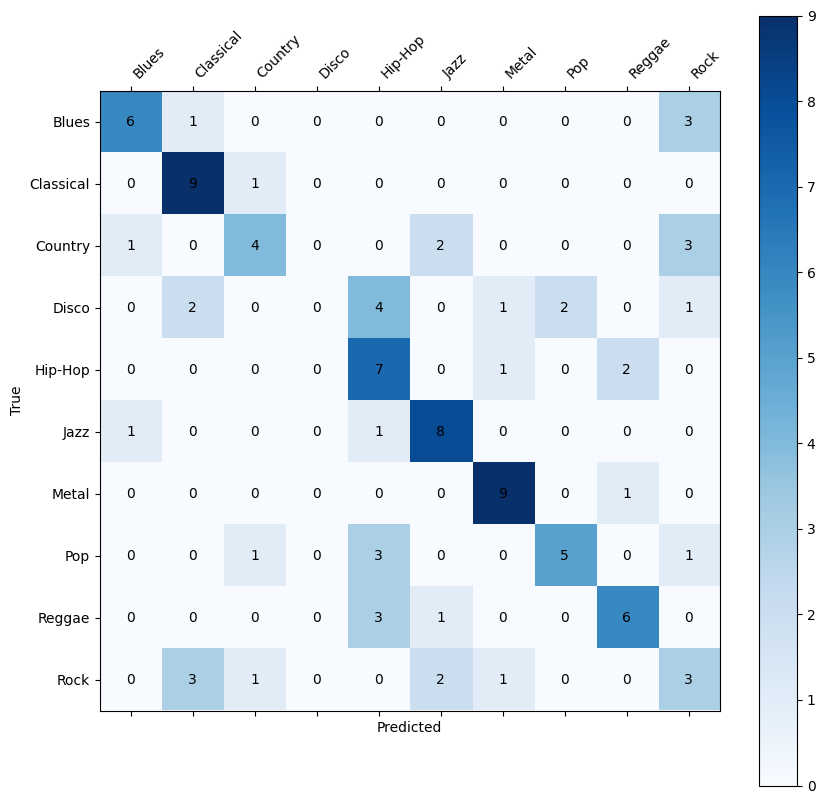

In [27]:
additional_metrics = create_post_loop_multiclass_metrics(num_classes=len(gtzan_classes))
merged_metrics = {**gtzan_multiclass_metrics, **additional_metrics}
results = test_loop(model_gtzan, merged_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has no TP in precision

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

In [ ]:
results['']

# Load FMA-small inputs

With val

In [14]:
BATCH_SIZE = 8
CHANNELS = 3

In [ ]:
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [ ]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=len(fma_small_top_classes)).to(device)

In [22]:
training_loop(model_fma_small, 8, fma_small_train_dl, fma_small_val_dl)

Epoch 1, Loss: 2.083809417039156
Validation Accuracy: 31.5%
Epoch 2, Loss: 1.6647054379433393
Validation Accuracy: 38.125%
Epoch 3, Loss: 1.5345848057791591
Validation Accuracy: 40.875%
Epoch 4, Loss: 1.4832319397851825
Validation Accuracy: 46.375%
Epoch 5, Loss: 1.4342508152127267
Validation Accuracy: 31.5%
Epoch 6, Loss: 1.400188159532845
Validation Accuracy: 46.875%
Epoch 7, Loss: 1.359112393297255
Validation Accuracy: 48.5%
Epoch 8, Loss: 1.3095306254550814
Validation Accuracy: 41.75%


In [28]:
test_loop(model_fma_small, fma_small_test_dl)

Test Accuracy: 37.875%


# Function definition for binary classification

In [28]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# Define binary metrics

In [35]:
binary_metrics=[tf.keras.metrics.BinaryAccuracy(),
                    #tf.keras.metrics.AUC(curve='ROC'),
                ]

# GTZAN binary classification

In [ ]:
#todo - actually find the 2 best classes

In [31]:
BATCH_SIZE = 8
CHANNELS = 3

In [26]:
GTZAN_CLASS_1 = 'Classical'
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [29]:
gtzan_train_df_2 = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_val_df_2 = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_test_df_2 = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [ ]:
gtzan_train_ds_2 = prepare_dataloader_based_on_df(gtzan_train_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_val_ds_2 = prepare_dataloader_based_on_df(gtzan_val_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_test_ds_2 = prepare_dataloader_based_on_df(gtzan_test_df_2, gtzan_binary_classes, BATCH_SIZE, CHANNELS)

Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00000.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00001.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00002.png' b'Classical'
Data set size: 160
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00011.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00022.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00027.png' b'Classical'
Data set size: 18
Example data:
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00004.png' b'Classical'
b'C:\\VisualStudioRepositories\\MUSIC_DATA\\gt\\Data\\spectrograms\\Classical\\classical.00006.png' b'Classical'
b'C:\\VisualStudi

In [33]:
model_gtzan_2 = create_CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_classes=2)

In [36]:
model_gtzan_2.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=binary_metrics)

In [38]:
model_gtzan_2.fit(
  gtzan_train_ds_2,
  validation_data=gtzan_val_ds_2,
  epochs=2
)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [ ]:
model_gtzan_2.evaluate(
  gtzan_test_ds_2
)